<a href="https://colab.research.google.com/github/roberth2018/Quantum-Machine-Learning/blob/main/House%20Price%20Prediction%20using%20qml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HOUSE PRICE PREDICTION USING QML

In [ ]:
pip install numba==0.49.1

In [ ]:
pip install tensornetwork==0.3

In [ ]:
!pip uninstall pennylane pennylane-sf -y


!pip install pennylane pennylane-sf 

import pennylane
dev = pennylane.device('default.tensor.tf', wires=6)

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pandas import read_csv
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:

house=np.loadtxt("dataqml.txt")

#transforming data
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
data = mm_scaler.fit_transform(house)

print(data.shape)

X = data[:, 0:3]
#X=2*X-1
Y = data[:, 3]
#Y=2*Y-1
xtr, xt, ytr, yt = train_test_split(X, Y, test_size=0.3)

(489, 4)


In [ ]:
def statepreparation(x0, x1, x2, nqbits):
    #original qbits A2 encoding
    qml.RY(x0, wires=[0])
    qml.RZ(x0, wires=[0])
    qml.RY(x1, wires=[1])
    qml.RZ(x1, wires=[1])
    qml.RY(x2, wires=[2])
    qml.RZ(x2, wires=[2])
    #copying qbits
    qml.RY(x0, wires=[3])
    qml.RZ(x0, wires=[3])
    qml.RY(x1, wires=[4])
    qml.RZ(x1, wires=[4])
    qml.RY(x2, wires=[5])
    qml.RZ(x2, wires=[5])
    
    for q in range(nqbits-1):
        qml.CNOT(wires=[q, q+1])
    
    qml.CNOT(wires=[nqbits-1, 0])
    
    #original qbits A2 encoding
    qml.RY(x0, wires=[0])
    qml.RZ(x0, wires=[0])
    qml.RY(x1, wires=[1])
    qml.RZ(x1, wires=[1])
    qml.RY(x2, wires=[2])
    qml.RZ(x2, wires=[2])
    #copying qbits
    qml.RY(x0, wires=[3])
    qml.RZ(x0, wires=[3])
    qml.RY(x1, wires=[4])
    qml.RZ(x1, wires=[4])
    qml.RY(x2, wires=[5])
    qml.RZ(x2, wires=[5])
   
    for q in range(nqbits-1):
        qml.CNOT(wires=[q, q+1])
    
    qml.CNOT(wires=[nqbits-1, 0])

    
def layer(theta):
    nqbits=len(theta[0])
    nlayer=len(theta)
    
    for l in range(nlayer):
        
        for i in range(nqbits-1):
            qml.CNOT(wires=[i, i+1])
        qml.CNOT(wires=[nqbits-1, 0])
        for q in range(nqbits):
            theta0=theta[l][q][0]
            theta1=theta[l][q][1]
            theta2=theta[l][q][2]
            qml.RX(theta0, wires=[q])
            qml.RZ(theta1, wires=[q])
            qml.RX(theta2, wires=[q])

nqbits=2*len(xt[0])
dev = qml.device('default.tensor.tf', wires=nqbits) 

@qml.qnode(dev)
def qcircuit(theta, x0, x1, x2):
    measure=[]
    nqbits=len(theta[0])
    statepreparation(x0, x1, x2, nqbits)
    layer(theta)
    for i in range(nqbits):
        zeta=qml.expval(qml.PauliZ([i]))
        measure.append(zeta)
    return measure

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def lparam(m, fz, y):
    mq=np.array(m) #orden nxfz
    beta1=np.matmul(np.linalg.inv(np.matmul(np.transpose(mq),mq )),np.transpose(mq))
    betas=np.matmul(beta1,y)
    return betas

def betas_model(theta,x0,x1,x2,y, fz):
    measure=[]
    for i in range(len(x1)):
        m=qcircuit(theta, x0[i],x1[i],x2[i])
        measure.append(m)
    mq=measure
    betas=lparam(mq, fz, y)
    return betas

def predictor(theta,x0,x1,x2,fz,betas):
    m=qcircuit(theta,x0,x1,x2)
    m=m[0:fz]
    matriz_pr=[]
    for i in range(fz):
        pr=m[i,]*betas[i,]
        matriz_pr.append(pr)
    pred=np.sum(matriz_pr)
    return pred

def total_cost(theta,x,y,fz):
    x0=x[:,0]
    x1=x[:,1]
    x2=x[:,2]
    betas=betas_model(theta,x0,x1,x2,y,fz)
    predi=[]
    for i in range(len(x0)):
        pred=predictor(theta,x0[i],x1[i],x2[i],fz,betas)
        predi.append(pred)
    predic=predi
    res=square_loss(y, predic)
    return res



In [ ]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)
num_qubits = 2*len(xt[0])
num_layers = 5
fz=6
theta_init = (0.01 * np.random.randn(num_layers, num_qubits, 3))
print(theta_init)
theta = theta_init

In [ ]:
for it in range(10):
    theta = opt.step(lambda v: total_cost(v, xtr, ytr, fz), theta)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, total_cost(theta, xtr, ytr,fz)))


Iter:     1 | Cost: 0.0084161 
Iter:     2 | Cost: 0.0083029 
Iter:     3 | Cost: 0.0082058 
Iter:     4 | Cost: 0.0081166 
Iter:     5 | Cost: 0.0080309 
Iter:     6 | Cost: 0.0079464 
Iter:     7 | Cost: 0.0078614 
Iter:     8 | Cost: 0.0077744 
Iter:     9 | Cost: 0.0076843 
Iter:    10 | Cost: 0.0075901 


Estadístico R_2: 0.82
Error cuadrático medio: 0.01


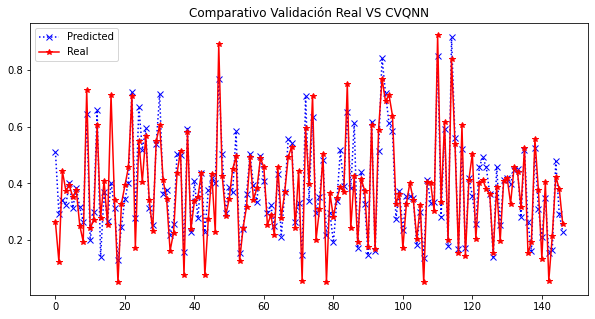

In [ ]:
#prediction test
betas=betas_model(theta,xtr[:,0],xtr[:,1],xtr[:,2],ytr,fz) 
#predics = [pedictor(theta, x0=xlo[:,0], x1=xlo[:,1], x2=xlo[:,2],
#           x3=xlo[:,3], x4=xlo[:,4], x5=xlo[:,5], x6=xlo[:,6], fz, betas) for xlo in xt]    

predics =[]
for i in range(len(xt)):
    p=predictor(theta,xt[i,0],xt[i,1],xt[i,2],fz,betas) 
    predics.append(p)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
#plt.plot(predics)
plt.plot(predics, marker="x", linestyle=':', color='b', label="Predicted")
plt.plot(yt, marker='*', linestyle='-', color='r', label ="Real")
plt.legend(loc="upper left")
plt.title('Comparativo Validación Real VS CVQNN')
#plt.plot(yt)


from sklearn.metrics import mean_squared_error, r2_score
# Por último, calculamos el error cuadrático medio y el estadístico R^2
print( u'Estadístico R_2: %.2f' % r2_score(yt, predics))
print( u'Error cuadrático medio: %.2f' % mean_squared_error(yt, predics))



In [ ]:
theta

tensor([[[ 0.0463074 , -0.10675016,  0.0535945 ],
         [-0.04395422, -0.09297391, -0.04491529],
         [-0.07004217,  0.05711297, -0.09882175],
         [-0.06125902, -0.046444  , -0.05035352],
         [ 0.01323087,  0.04349164,  0.01658512],
         [-0.05066405,  0.07373617, -0.04353711]],

        [[ 0.03428112, -0.02268844,  0.02652685],
         [-0.04355332,  0.06118439, -0.04002815],
         [ 0.05786502,  0.05690346,  0.05204826],
         [ 0.03902654, -0.10466913,  0.02713133],
         [-0.11865706, -0.0839039 , -0.09228555],
         [-0.03659055,  0.06340156, -0.01511189]],

        [[-0.05385148, -0.02852629, -0.04065777],
         [-0.05640833, -0.07150499, -0.05091696],
         [ 0.00542371,  0.14425702,  0.00217176],
         [-0.06731243,  0.0691234 , -0.0471026 ],
         [-0.05552268, -0.05465045, -0.05290029],
         [ 0.07856297, -0.06319655,  0.07669066]],

        [[ 0.04780471,  0.03358681,  0.01895745],
         [-0.05277713, -0.04377458, -0.07428